In [1]:
import os, requests
import numpy as np
from scipy import signal, fftpack
from matplotlib import rcParams
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [2]:
#对所有channel的value进行

def get_filtered_chan_value(subject_chan_values,bandwidth, fs,order = 2):

   
    #fs = 1000  # 采样频率要写在函数里面还是函数外面
    lowcut = bandwidth[0]#4.0  # 低频截止频率
    highcut = bandwidth[1]#20.0 # 高频截止频率
    

    # 设计Butterworth带通滤波器
    b, a = signal.butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')

    # 应用带通滤波器
    filtered_all_chan_values = signal.filtfilt(b, a, subject_chan_values,axis=0)

    #return filtered_all_chan_values
    return np.squeeze(filtered_all_chan_values)

In [3]:
def get_fft(data,time,fs):

    
    fft_values = fftpack.fft(data, axis=0)
    
    fft_freq= fftpack.fftfreq(time, d=1/fs)


    select_fre = len(fft_freq)//2+1 
    
    return fft_values[:select_fre,...],fft_freq[:select_fre]



def get_fft_values(all_chan_values, filtered_all_chan_values, fs):

    time , channels = all_chan_values.shape

    fft_values_notch,fft_freq_notch = get_fft(data=all_chan_values,
                                              fs=fs,
                                              time=time)


    fft_values_notch_band ,fft_freq_notch_band = get_fft(data=filtered_all_chan_values,
                                                         fs=fs,
                                              time=time)

    return fft_values_notch, fft_freq_notch, fft_values_notch_band, fft_freq_notch_band

    
    '''fft_values_notch_band = fftpack.fft(filtered_all_chan_values, axis=0)

    fft_freq_notch_band = fftpack.fftfreq(time, d=1/fs)'''
    
    

In [4]:


#进行短时傅里叶变换

def get_stft_chan_values(all_chan_values, filtered_all_chan_values, fs):

    npersegi = min(64, len(all_chan_values[0])) 

    f_notch, t_notch, Zxx_notch = signal.stft(all_chan_values.T,
                                              fs, 
                                              nperseg = npersegi,
                                              axis=-1)

    nperseg_filtered = min(64, len(filtered_all_chan_values[0])) 
    
    f_notch_band, t_notch_band, Zxx_notch_band = signal.stft(filtered_all_chan_values.T, 
                                                             fs,
                                                             nperseg = nperseg_filtered, 
                                                             axis=-1)

    
    return f_notch, t_notch, Zxx_notch, f_notch_band, t_notch_band, Zxx_notch_band

In [9]:

def plot(raw_data,
         raw_data_filtered,
         
        fft_raw_values,
         fft_raw_freq,

         fft_values_band,
         fft_freq_band,
         
         project_index,
         subject_index,
         
        plot_bandwodth):

    
    plt.figure(figsize=(12, 8))

    
    # 计算原始数据的平均值和标准差
    raw_avg = np.mean(raw_data, axis=-1)
    raw_std = np.std(raw_data, axis=-1)
    x = np.arange(len(raw_avg))/1000
    
    # 绘制原始数据
    plt.subplot(4, 1, 1)
    plt.plot(x,raw_avg)
    plt.fill_between(x, raw_avg - raw_std, raw_avg + raw_std, alpha=0.6)
    plt.xlabel('Time (s)')
    plt.title(f'Project {project_index}, Subject {subject_index} - Raw Data')

    
    # 计算过滤后数据的平均值和标准差
    filter_avg = np.mean(raw_data_filtered, axis=-1)
    filter_std = np.std(raw_data_filtered, axis=-1)

    # 绘制过滤后的数据
    plt.subplot(4, 1, 2)
    plt.plot(x,filter_avg)
    plt.fill_between(x, filter_avg - filter_std, filter_avg + filter_std, alpha=0.6)
    plt.title('Filtered Data')
    plt.xlabel('Time (s)')


    
    #fft_raw_freq = fft_raw_freq*500
    
    #plt.xlim(0, fs / 2)
    # 绘制FFT数据
    plt.subplot(4, 1, 3)
    # 做频率限制,索引带宽的值的位置
    index_out_100 = np.array(np.where((fft_raw_freq >= plot_bandwodth[0]) & (fft_raw_freq<= plot_bandwodth[1])))
    avg = np.mean(np.abs(fft_raw_values),axis=-1)

    print(avg.shape)
    # 绘制FFT数据
    plt.plot(fft_raw_freq[index_out_100[0]], avg[index_out_100[0]])
    plt.title('FFT of Raw Data')


    #fft_freq_band = fft_freq_band*500
    # 做频率限制,索引带宽的值的位置
    index_out_100 = np.array(np.where((fft_freq_band >= plot_bandwodth[0]) & (fft_freq_band<= plot_bandwodth[1])))

    filter_avg = np.mean(np.abs(fft_values_band),axis=-1)
    plt.subplot(4, 1, 4)
    plt.plot(fft_freq_band[index_out_100[0]], filter_avg[index_out_100[0]])
    plt.title('FFT of Filtered Data')
    #plt.xlim(0, fs / 2)
    
    plt.tight_layout()

    plt.show()



def plot_stft(t_notch, f_notch, Zxx_notch,t_notch_band, f_notch_band,Zxx_notch_band,
              project_index,subject_index):
        #绘制STFT数据
    # channel x f x time
    plt.figure(figsize=(12, 4))

    avg = np.mean(np.abs(Zxx_notch),axis=0)
    
    plt.subplot(2, 1, 1)
    plt.pcolormesh(t_notch, f_notch,avg  , shading='gouraud')
    plt.title(f'Project {project_index}, Subject {subject_index} - STFT of Raw Data')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time (s)')
    plt.ylim(0, 50)
    plt.colorbar()
    plt.tight_layout()


    filter_avg = np.mean(np.abs(Zxx_notch_band),axis=0)
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t_notch_band, f_notch_band, filter_avg, shading='gouraud')
    plt.title('STFT of Filtered Data')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time (s)')
    plt.colorbar()
    plt.ylim(0, 50)
    plt.tight_layout()
    plt.show()


(186381,)


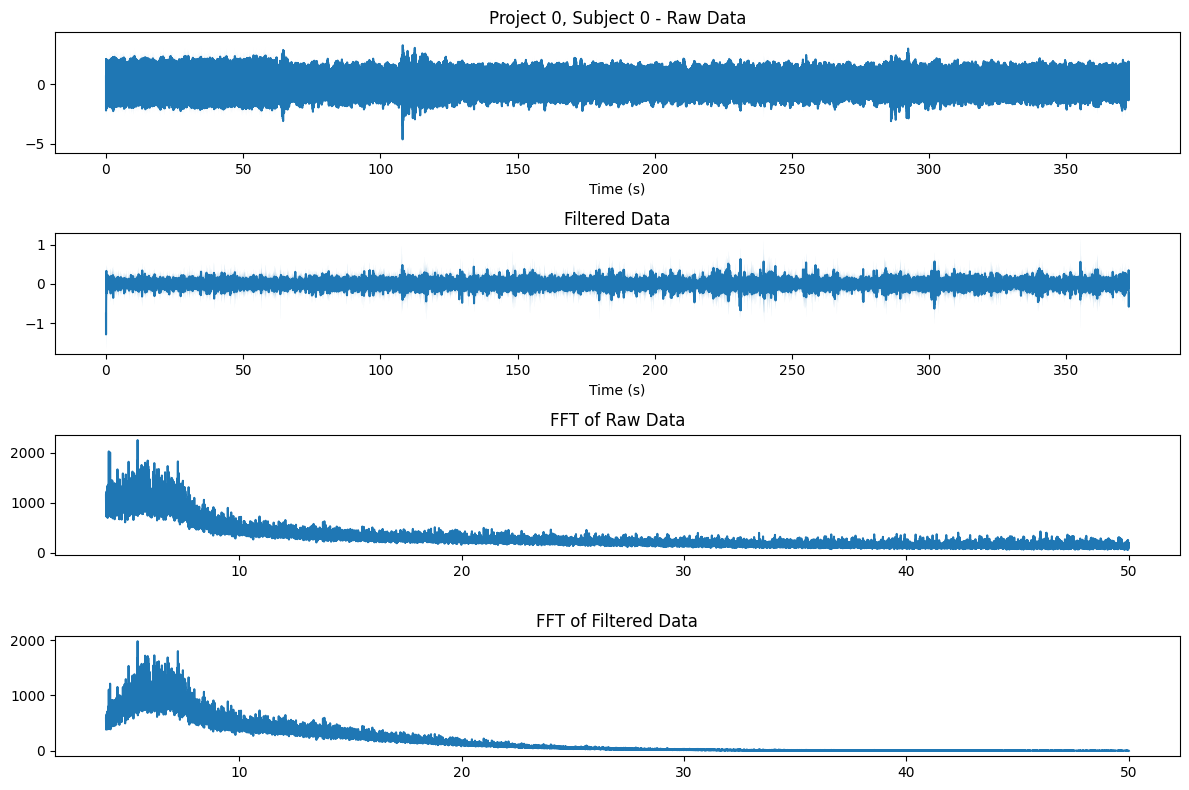

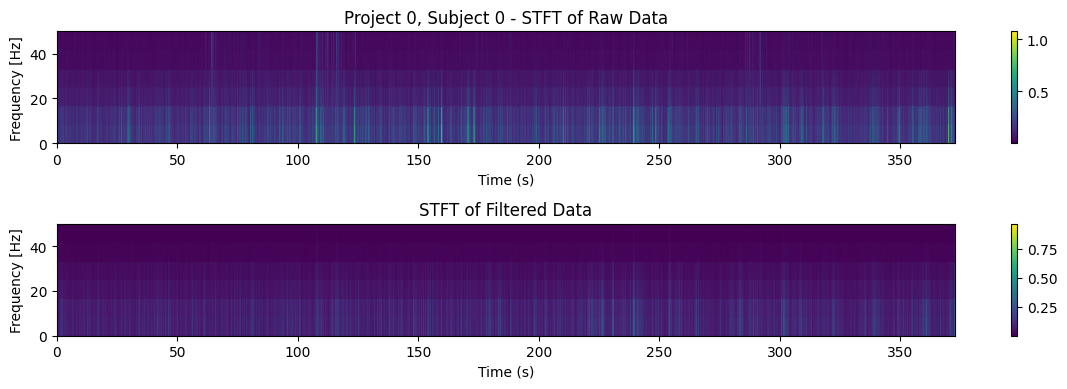

(124321,)


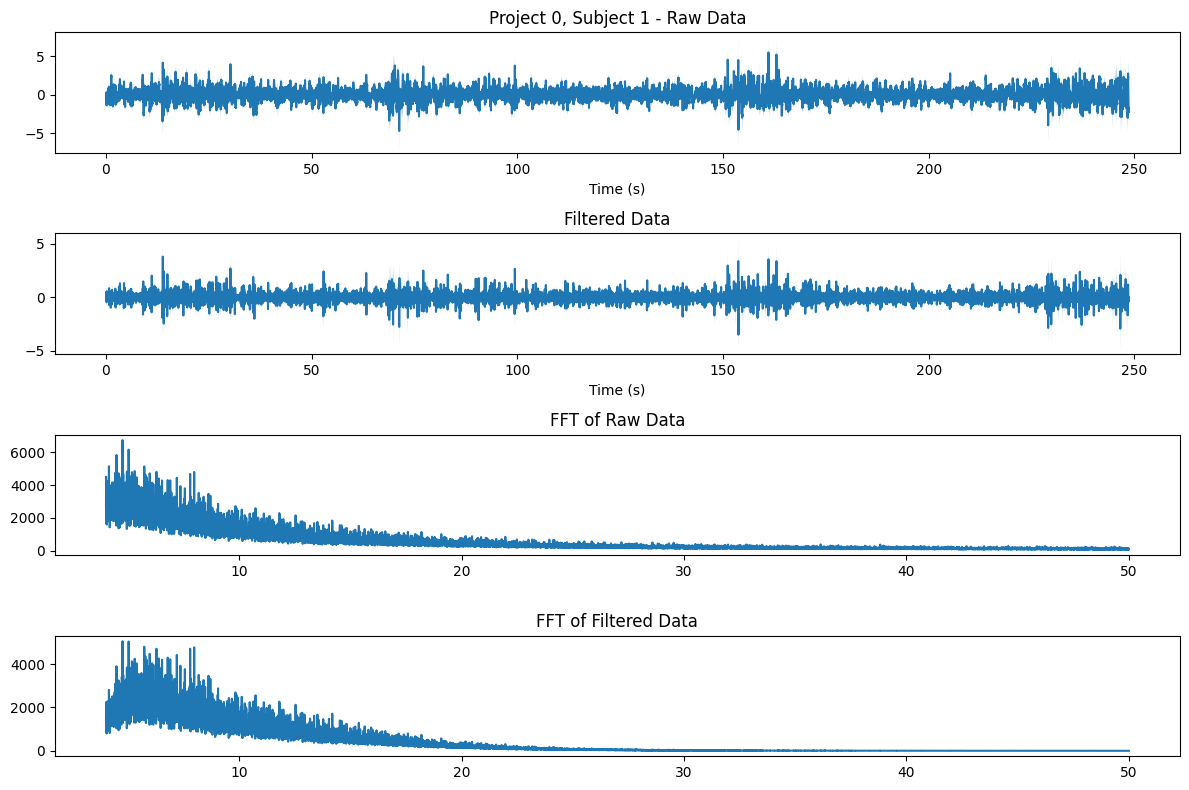

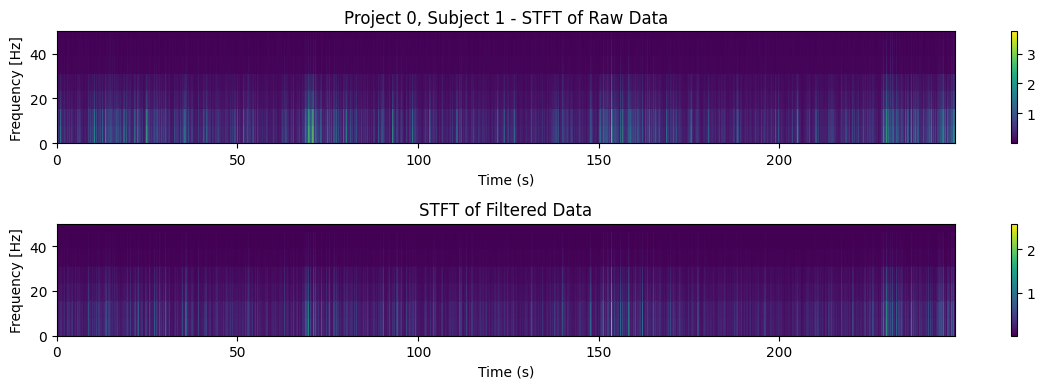

(67181,)


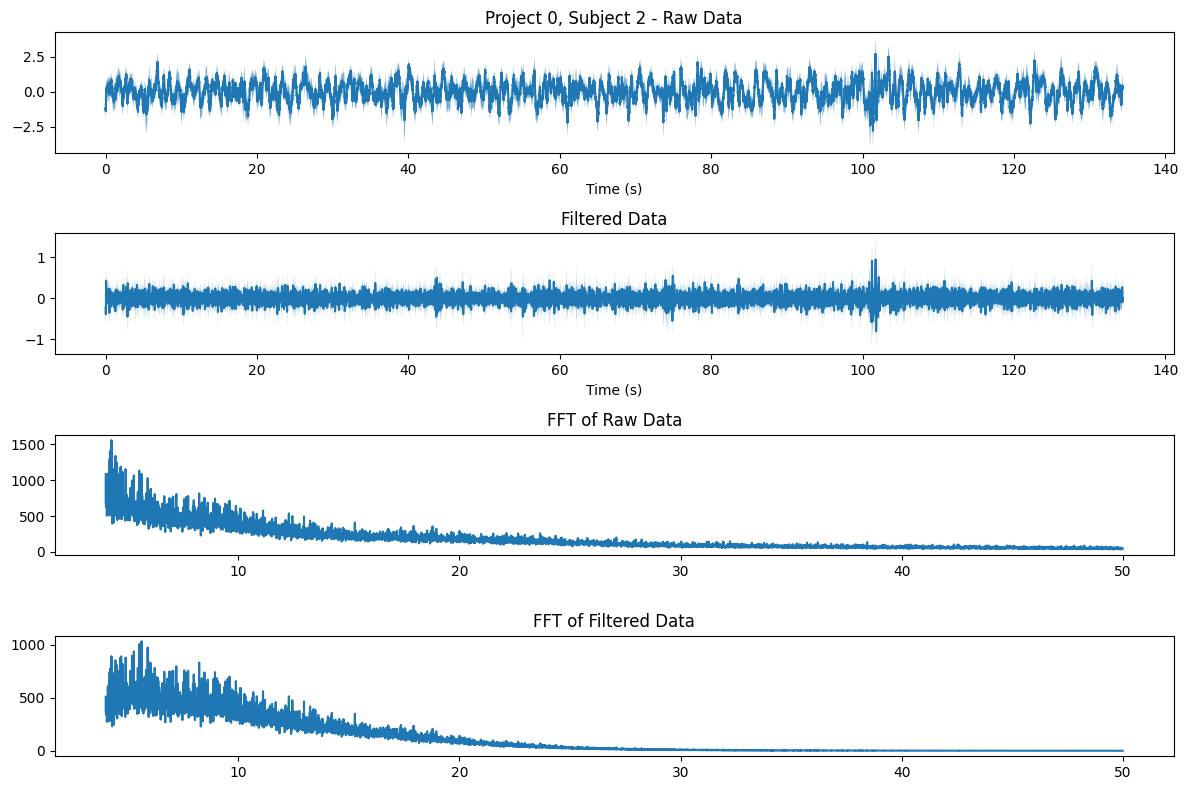

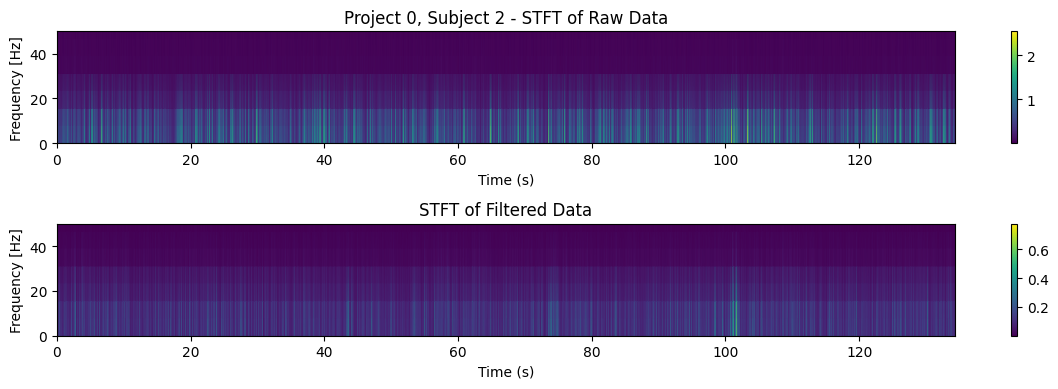

(129961,)


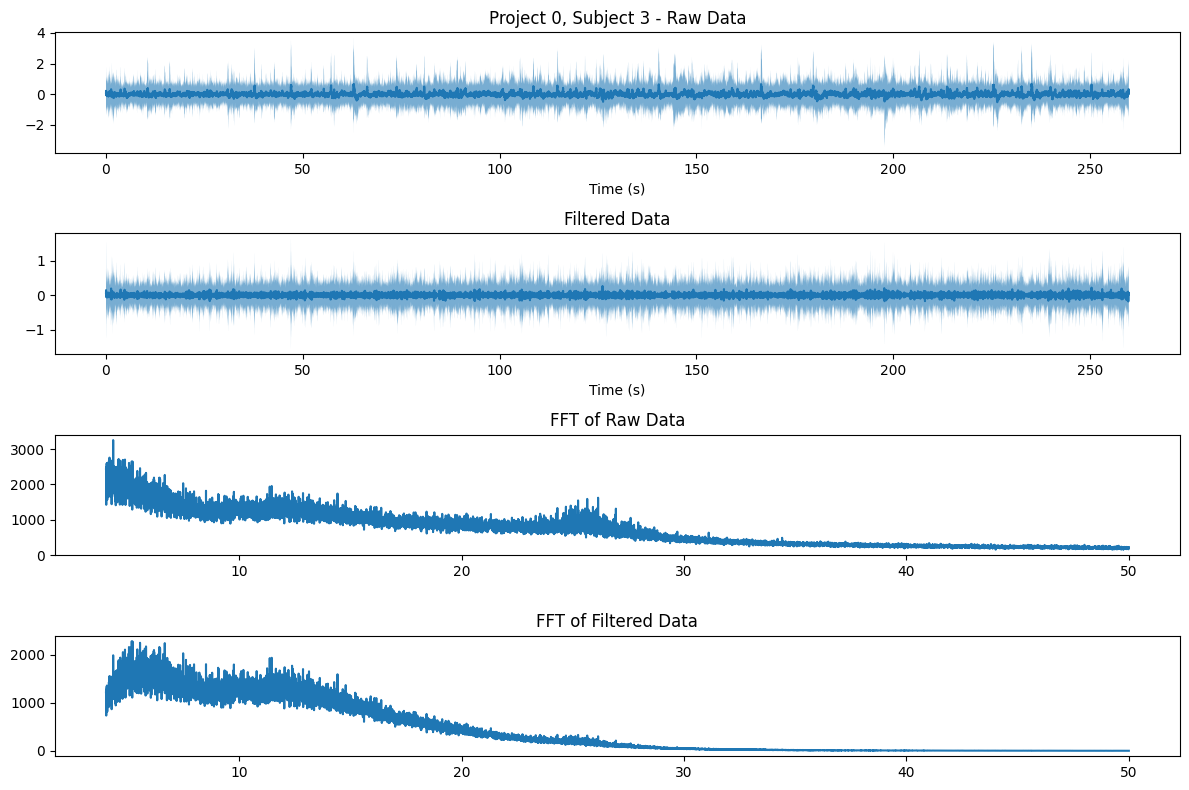

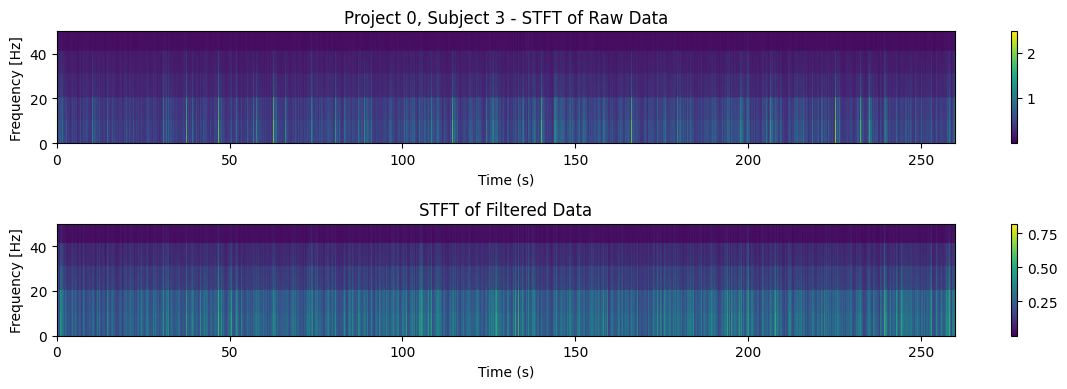

In [10]:
folder_path = 'D:/code/neuromatch/joystick_track.npz'


Data = np.load(folder_path, allow_pickle=True)['dat']

fs = 1000 #采样率

#设置subject_channel的空集以方便后续在循环中将channel的值填入
subject_chan_values = []  # 每次处理一个被试时重新初始化列表
bandwidth=[4,20]
#通过循环读project
for project_index, project in enumerate(Data):


    #通过循环读project下的四个被试
    for subject_index, subject in enumerate(project):


        V = np.array(subject['V'],dtype=np.float32)

        subject_chan_values.append(V)

        #对读取的数据进行Bandfilter
        filtered_ECoG_data = get_filtered_chan_value(V , bandwidth, fs)

        
        #对原始数据和过滤后的数据分别进行fourier transform
        ft_values_notch, fft_freq_notch, ft_values_notch_band, fft_freq_notch_band = get_fft_values(all_chan_values=V, 
                                                                                                    filtered_all_chan_values=filtered_ECoG_data, 
                                                                                                    fs=fs)



        #对原始数据和过滤后的数据分别进行short-time-fourier transform
        f_notch, t_notch, Zxx_notch, f_notch_band, t_notch_band, Zxx_notch_band = get_stft_chan_values(all_chan_values=V, 
                                                                                                       filtered_all_chan_values=filtered_ECoG_data,
                                                                                                       fs=fs)

         
        
        plot(raw_data=V,
             raw_data_filtered=filtered_ECoG_data,
             fft_raw_values=ft_values_notch,
             fft_raw_freq=fft_freq_notch,
              fft_values_band=ft_values_notch_band,
             fft_freq_band=fft_freq_notch_band,
             project_index=project_index,
             subject_index=subject_index,
            plot_bandwodth=[4,50])
    
        
        plot_stft(t_notch, 
                  f_notch,
                  Zxx_notch,
                  t_notch_band,
                  f_notch_band,
                  Zxx_notch_band,
                  project_index,
                  subject_index)

    

